# Optimization using or tools

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

### Loading the data 

In [2]:
df = pd.read_excel('data_optim.xls')

### Import OR tools

In [3]:
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

## Formulation of optim problem

**$ max \sum_{h \in heures} Prix(h)\times(-Edecharge(h)-Echarge(h))$**

[1]$0 \leq Echarge(h) \leq Pmax $        

[2] $ -Pmax \leq Edecharge(h) \leq 0 $     

[3] $ SoC(h+1) = SoC(h) + \rho Edecharge(h)+Echarge(h) $      

[4] $0 \leq SoC(h) \leq Emax $                      

[5] $ SoC(0) = 0$                                 

In [4]:
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

# Creates the variables.
price = df.Prix.tolist()
nhours = len(price)
Pmax = 1
Emax = 1 
rho = 0.9

## Create variables

In [7]:
# Create variables
# Echarge[i] is an array of 0-1 variables, which will be 1 if there is a charge is the hours
Echarge = {}
for i in range(nhours):
    Echarge[i] = solver.NumVar(0, Pmax, '')
Edecharge = {}
for i in range(nhours):
    Edecharge[i] = solver.NumVar(-Pmax,0,'')
SoC ={}
for i in range(nhours):
    SoC[i]  = solver.NumVar(0,Emax,'')

## Create the constraints

In [9]:
# Initialization constraints
solver.Add(SoC[0]==0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7fc14c0ee420> >

In [10]:
# Each task is assigned to exactly one worker.
for h in range(nhours-1):
    solver.Add(SoC[h+1] == SoC[h]+rho*Echarge[h]+Edecharge[h] )

## Create the objective function

In [11]:
objective_terms = []
for h in range(nhours):
    objective_terms.append(-price[h] * (Echarge[h]+Edecharge[h]))

In [12]:
solver.Maximize(solver.Sum(objective_terms))

In [13]:
status = solver.Solve()

In [15]:
solver.Objective().Value()

814.582888888889

In [16]:
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print('Total cost = ', solver.Objective().Value(), '\n')
    sol_charge  =[]
    sol_decharge = []
    sol_SoC = []
    for h in range(nhours):
        sol_charge.append(Echarge[h].solution_value())

        sol_decharge.append(Edecharge[h].solution_value())

        sol_SoC.append(SoC[h].solution_value())

Total cost =  814.582888888889 



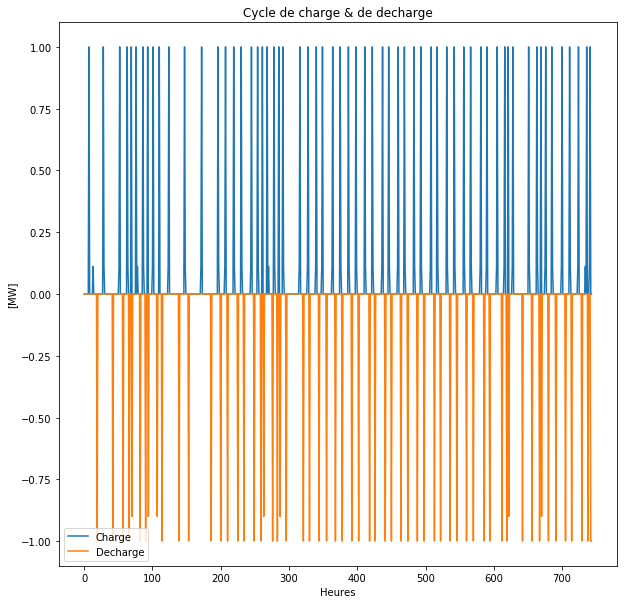

In [43]:
plt.figure(figsize=(10,10))
plt.plot(sol_charge,label='Charge')
plt.xlabel('Heures')
plt.ylabel('[MW]')
plt.plot(sol_decharge,label='Decharge')
plt.title('Cycle de charge & de decharge')
plt.legend()
plt.show()

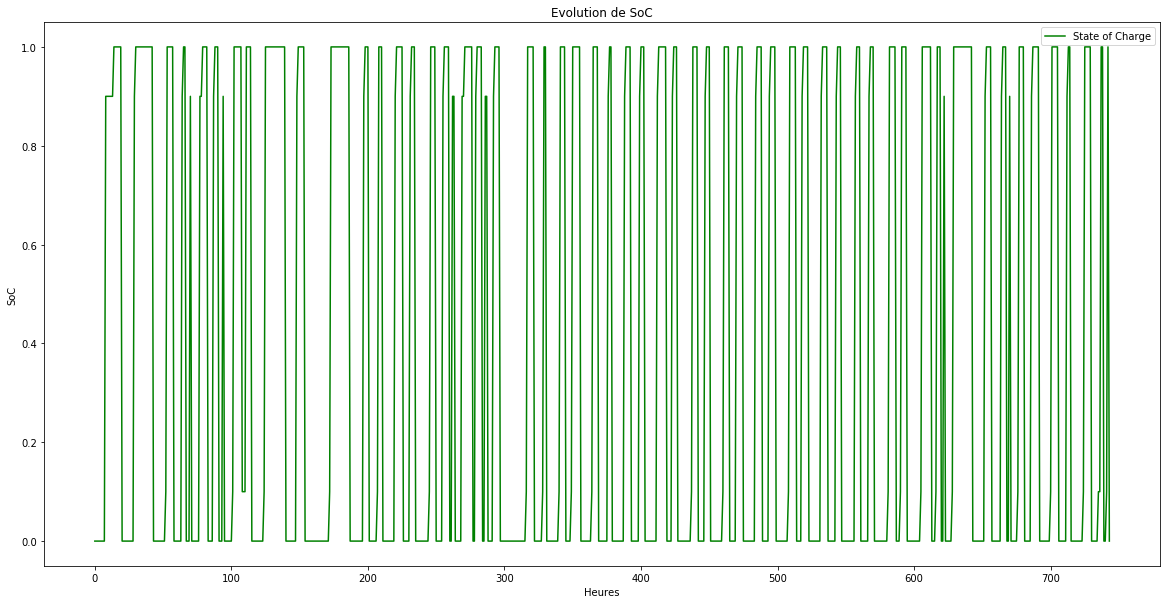

In [44]:
plt.figure(figsize=(20,10))
plt.plot(sol_SoC,c="g",label="State of Charge")
plt.xlabel('Heures')
plt.ylabel('SoC')
plt.title('Evolution de SoC')
plt.legend()
plt.show()

In [24]:
profit = []
for h in range(nhours):
    p = price[h]*(sol_charge[h]+sol_decharge[h])*-1
    profit.append(p)

In [26]:
sum(profit)

814.5828888888891